In [26]:
%matplotlib inline
import jax
import jax.numpy as jnp

import galsim
import numpy as np
import proplot as pplt
from fpfs.imgutil import gauss_kernel


+ https://gist.github.com/beckermr/3ee7f7ca8924d9b65d0f22473e45aa61
+ This notebook shows some experimental tests based on Matthew's example
+ FPFS with adaptive kernel

In [18]:
def _adaptive_shape_kern(im, sigma2):
    half = ngrid//2
    y, x = jnp.mgrid[:32, :32]
    y = y - half
    x = x - half
    
    kern = jnp.exp(
        -0.5 * x * x / sigma2
        -0.5 * y * y / sigma2
    )
    
    norm = jnp.sum(im * kern)
    mx2 = jnp.sum(x * x * kern * im) / norm
    my2 = jnp.sum(y * y * kern * im) / norm

    
    # adaptive moments has this deweighting thing
    # I got this snippet out of ngmix
    idetm = 1.0 / (mx2 * my2)
    idetw = 1.0 / sigma2 / sigma2
    Nrr = mx2*idetm - sigma2*idetw  # Nrr = Icc*idetm - Wcc*idetw
    Ncc = my2*idetm - sigma2*idetw  # Ncc = Irr*idetm - Wrr*idetw
    detn = Nrr*Ncc

    # now set from the inverted matrix
    idetn = 1.0/detn
    mx2 = Ncc*idetn
    my2 = Nrr*idetn
    
    new_sigma2 = (mx2 + my2)/2.0
    
    return new_sigma2


def dumb_adaptive_thing(im):
    sigma2 = (2.0/0.2/2.355)**2
    for _ in range(10):
        sigma2 = _adaptive_shape_kern(im, sigma2)
    return sigma2

# Adaptive size estimation and its derivatives
vg = jax.jit(jax.value_and_grad(dumb_adaptive_thing, 0))

# Gaussian Smoothing
def get_smooth_img(im, smooth_scale_fourier=2.5):
    gsigma=smooth_scale_fourier*2.*np.pi/ngrid
    gKer, (k2grid,k1grid) =gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    # convolution
    imF=np.fft.fft2(im)*gKer
    # back to configuration space
    imCov=np.fft.ifft2(imF).real
    return imCov
    
# pixel response in Li & Mandelbaum 2023
def get_shear_response(im, smooth_scale_fourier=2.5):
    gsigma=smooth_scale_fourier*2.*np.pi/ngrid
    gKer, (k2grid,k1grid) =gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    # convolution
    imF=np.fft.fft2(im)*gKer
    # shear response of convolved image
    imFQA=imF*(k1grid**2.-k2grid**2.)/gsigma**2.
    imFQB=imF*(2.*k1grid*k2grid)/gsigma**2.
    imFDA=imF*(-1j*k1grid)
    imFDB=imF*(-1j*k2grid)
    
    # back to configuration space
    imCov=np.fft.ifft2(imF).real
    imCovQA=np.fft.ifft2(imFQA).real
    imCovQB=np.fft.ifft2(imFQB).real
    imCovDA=np.fft.ifft2(imFDA).real
    imCovDB=np.fft.ifft2(imFDB).real
    ygrid,xgrid = np.meshgrid(np.fft.fftfreq(ngrid,1/ngrid),np.fft.fftfreq(ngrid,1/ngrid),indexing='ij')
    xgrid=np.fft.fftshift(xgrid)
    ygrid=np.fft.fftshift(ygrid)
    return imCovQA+xgrid*imCovDA-ygrid*imCovDB

In [55]:
# image
ngrid = 32
obj = galsim.Exponential(half_light_radius=0.5/0.2).shear(e1=0.1, e2=-0.14)
im = obj.shift(0.5,0.5).drawImage(nx=ngrid, ny=ngrid, scale=1).array

In [73]:
%time
im_sm = get_smooth_img(im)
im_sr = get_shear_response(im)
sigma2, dsigma2_dimsm = vg(im_sm)
dsigma2_dg = jnp.sum(dsigma2_dimsm*im_sr)
print(r"The estimated $\sigma^2$ is: %.3f" %sigma2)
print("The estimated shear response is: %.3f" %dsigma2_dg)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15.3 µs
The estimated $\sigma^2$ is: 8.873
The estimated shear response is: 0.704


Text(0.5, 1.0, '$\\mathrm{d}\\sigma^2/\\mathrm{d}f_x$')

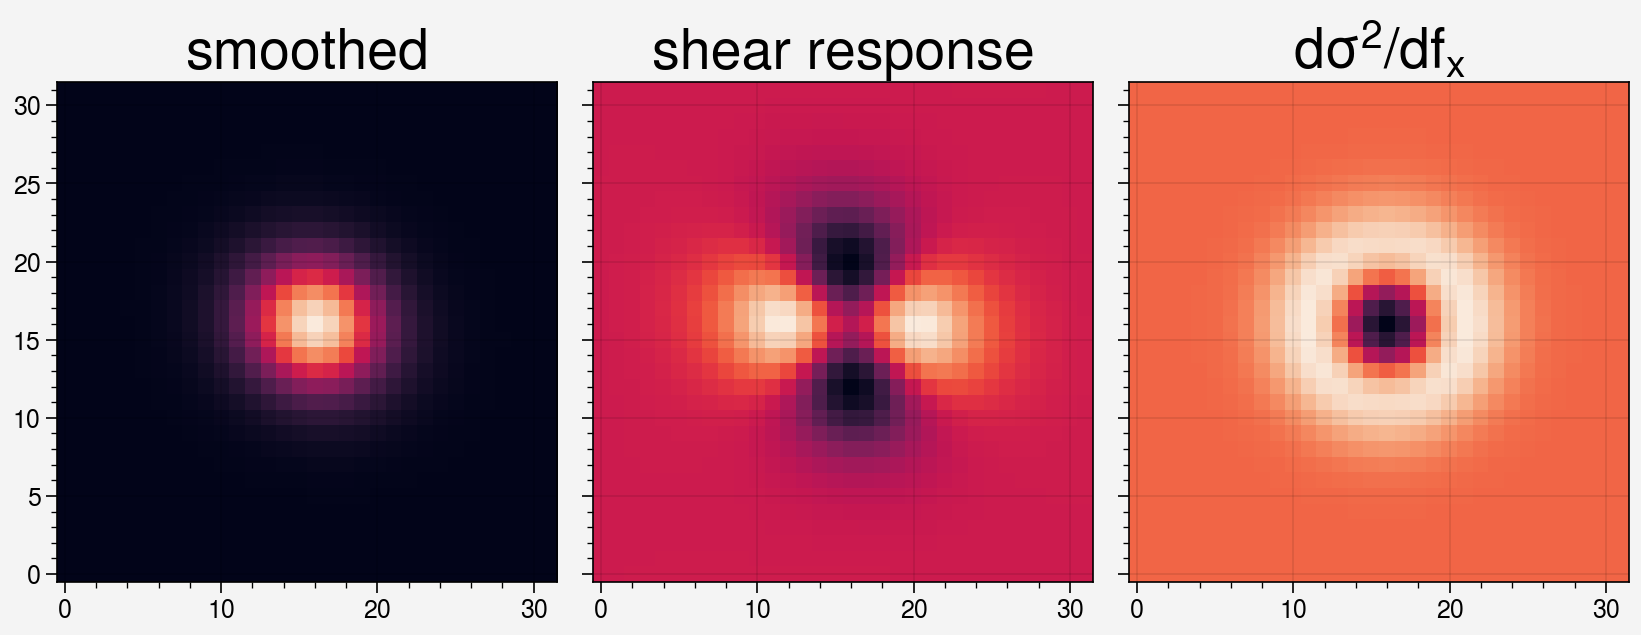

In [63]:
pplt.close()
fig, axs = pplt.subplots(ncols=3, nrows=1)
axs[0].imshow(im_sm, origin="lower", cmap="rocket")
axs[0].set_title("smoothed", fontsize = 20)
axs[1].imshow(im_sr, origin="lower", cmap="rocket")
axs[1].set_title("shear response", fontsize = 20)

axs[2].imshow(dsigma2_dimsm, origin="lower", cmap="rocket")
axs[2].set_title("$\mathrm{d}\sigma^2/\mathrm{d}f_x$", fontsize = 20)

In [71]:
obj_2 = obj.shear(g1=0.03)
im_2 = obj_2.shift(0.5,0.5).drawImage(nx=ngrid, ny=ngrid, scale=1).array

im_sm_2 = get_smooth_img(im_2)
im_sr_2 = get_shear_response(im_2)
sigma2_2, dsigma2_dimsm_2 = vg(im_sm_2)
dsigma2_dg_2 = jnp.sum(dsigma2_dimsm_2*im_sr_2)
print(r"The estimated $\sigma^2$ is: %.3f" %sigma2_2)
print("The estimated shear response is: %.3f" % dsigma2_dg_2)

The estimated $\sigma^2$ is: 8.900
The estimated shear response is: 1.128


Text(0.5, 1.0, '$\\mathrm{d}\\sigma^2/\\mathrm{d}f_x$')

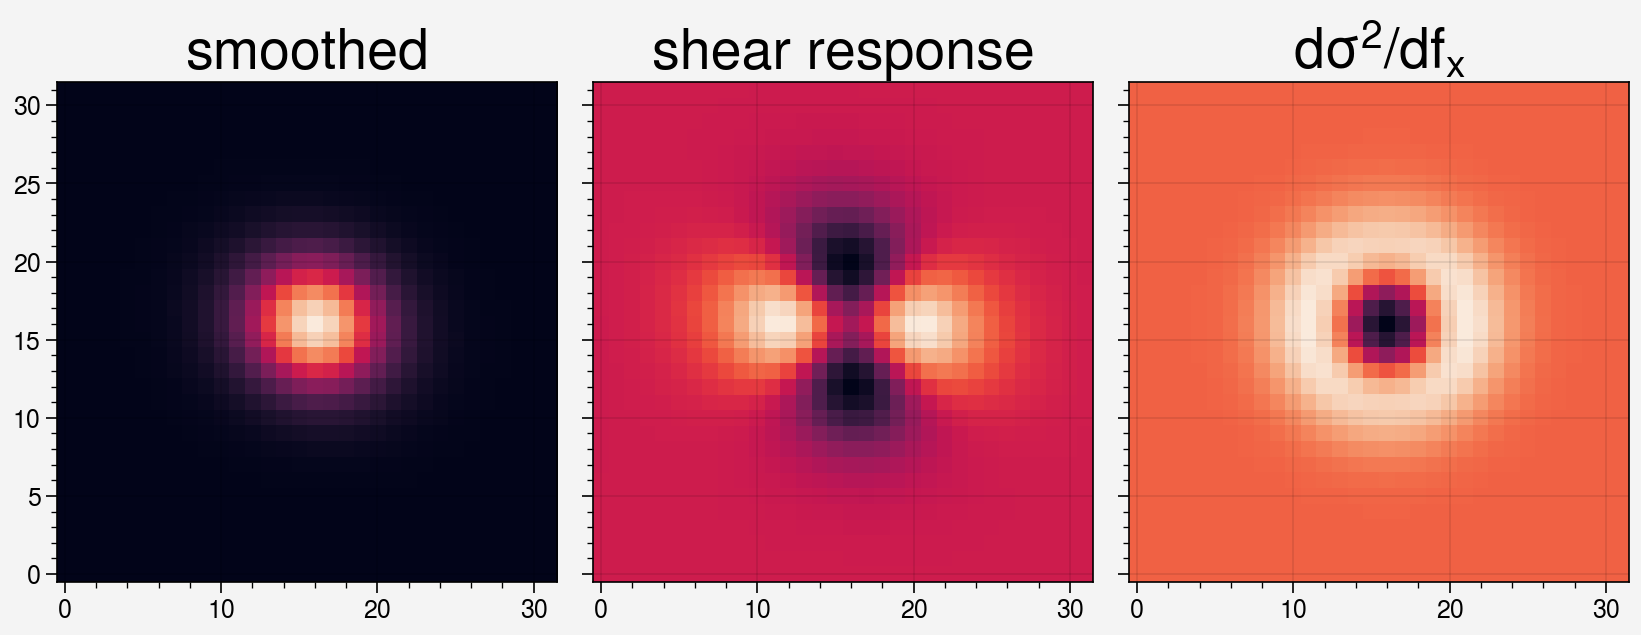

In [70]:
pplt.close()
fig, axs = pplt.subplots(ncols=3, nrows=1)
axs[0].imshow(im_sm_2, origin="lower", cmap="rocket")
axs[0].set_title("smoothed", fontsize = 20)
axs[1].imshow(im_sr_2, origin="lower", cmap="rocket")
axs[1].set_title("shear response", fontsize = 20)

axs[2].imshow(dsigma2_dimsm_2, origin="lower", cmap="rocket")
axs[2].set_title("$\mathrm{d}\sigma^2/\mathrm{d}f_x$", fontsize = 20)

In [81]:
print('Numerical estimation with simulation is: %.3f' %((sigma2_2 - sigma2)/0.03))

Numerical estimation with simulation is: 0.913


In [80]:
print('Anatical estimation with autodiff: %.3f' %((dsigma2_dg_2 + dsigma2_dg)/2.))

Anatical estimation with autodiff: 0.916
